# Interprtable Machine Learning with LIME for Image Classification Model

### Importing libraries

In [77]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.4.3


### Loading the pre-trained InceptionV3 model

In [78]:
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model

### Read and preprocess an image

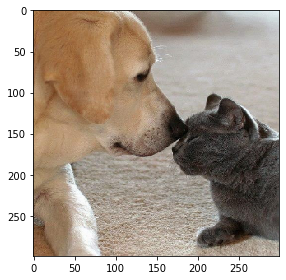

In [79]:
Xi = skimage.io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
#Xi = skimage.io.imread("Peacock.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) #Show image before inception preprocessing

### Predict the class of the image

In [80]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes

[('n02099712', 'Labrador_retriever', 0.82733554),
 ('n02099601', 'golden_retriever', 0.014789611),
 ('n02093428', 'American_Staffordshire_terrier', 0.008711366),
 ('n02108422', 'bull_mastiff', 0.00817788),
 ('n02109047', 'Great_Dane', 0.007899453)]

### Indexes of the top 5 classes predicted

In [81]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes #Index of top 5 classes

array([208, 207, 180, 243, 246], dtype=int64)

### Create super pixels for the image

In [82]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4, max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

68

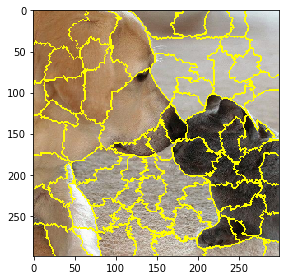

In [83]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

### Create random perturbations

In [84]:
num_perturb = 20 #Create 20 pertubations, use a large number for a better interpretation
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
print('Shape = ', perturbations.shape)
print('First pertubation = ', perturbations[0]) #Show example of perturbation

Shape =  (20, 68)
First pertubation =  [1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1
 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1]


#### Perturbation function

In [85]:
#The following function perturb_image perturbs the given image (img) 
#based on a perturbation vector (perturbation) and predefined superpixels (segments).
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

#### Apply perturbation function to perturbed a given image using a given perturbation vector

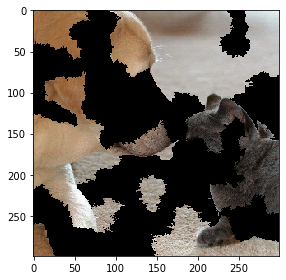

In [86]:
#pertubes the image using the pertubation vector pertubations[0]
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels)) 

### Use ML classifier (InceptionV3) to predict the classes of perturbed images

In [87]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(20, 1, 1000)

### Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image

In [88]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(20,)

#### Use a kernel function to compute weights

In [89]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(20,)

### Use perturbations, predictions and weights to fit an explainable (linear) model

In [90]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 1.18016266e-01, -1.40086612e-03,  5.77702963e-02, -9.56251797e-02,
        6.63775438e-02,  2.26324126e-02, -1.73255412e-05, -3.33642483e-02,
        8.05164301e-02, -5.86678188e-02, -1.30534167e-02,  2.09758847e-02,
        3.15878039e-02, -4.22307133e-02,  2.92432387e-02, -2.32910744e-02,
        3.86810015e-02,  1.39669194e-02,  2.41733131e-02,  3.40327020e-02,
        1.03586103e-01,  6.68013395e-02, -1.49121143e-02, -2.94452790e-02,
        8.98257305e-02, -8.25028333e-03,  1.23854313e-02, -3.70107034e-02,
       -2.96326157e-03, -7.49477598e-02,  2.23706225e-02,  3.74816329e-02,
        2.35495248e-02,  2.63575078e-02, -8.38145210e-03, -1.10541049e-01,
       -1.30724243e-01, -1.11964506e-01,  5.21973409e-02,  7.91509537e-02,
       -9.89987904e-03, -1.40886293e-02, -3.51669041e-02,  3.78145516e-02,
        6.78567384e-02, -9.70486066e-03,  4.19456223e-02,  3.04347767e-02,
       -3.55411364e-02, -4.19024187e-02,  7.75316395e-02,  4.34277298e-02,
       -7.18326633e-03,  

#### Compute top features (superpixels)

In [91]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([24, 20, 67,  0], dtype=int64)

#### Show LIME explanation (image with top features)

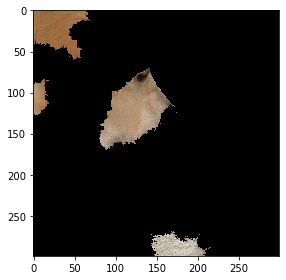

In [92]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )